# hypothesis 5: representatives from more religious districts use religious speech more

# load data and imports

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os

tqdm.pandas()

In [74]:
DATA_PATH = "/data/laviniad/congress_errata/classed_congress_df.json"
df = pd.read_json(DATA_PATH)
df['date'] = pd.to_datetime(df['date'].apply(str), format='%Y%m%d')
df['month'] = df['date'].dt.month

In [75]:
raw_df = df.copy()

In [76]:
df = raw_df.copy() # rerun to avoid having to reload the json

# filter

In [77]:
def is_dem_rep(t):
    return (t == 'Democrat') or (t == 'Republican')

def not_procedural_unknown_topic(x):
    return (not ('Procedural' in x)) and (not ('Unknown' in x))

def is_long(x, thresh=5): # takes string, whitespace heuristic
    return len(x.split()) > thresh

def is_in_range(x):
    return x in range(1995, 2023)

df = df[df['party'].progress_apply(is_dem_rep)]
#df = df[df['main_topic'].progress_apply(not_procedural_unknown_topic)]
df = df[df['year'].progress_apply(is_in_range)]
df = df[df['text'].progress_apply(is_long)]

  0%|          | 0/1328805 [00:00<?, ?it/s]

  0%|          | 0/1203575 [00:00<?, ?it/s]

  0%|          | 0/1182286 [00:00<?, ?it/s]

In [78]:
print(f"Filtered out {len(raw_df) - len(df)} rows")
print(f"New length: {len(df)}")

Filtered out 147411 rows
New length: 1181394


In [79]:
print("Getting 118th Congress df")
df_118_117 = raw_df[(raw_df['congress_num'] == 118) | (raw_df['congress_num'] == 117)]
df_118_117 = df_118_117[df_118_117['party'].progress_apply(is_dem_rep)]
df_118_117 = df_118_117[df_118_117['text'].progress_apply(is_long)]

Getting 118th Congress df


  0%|          | 0/78538 [00:00<?, ?it/s]

  0%|          | 0/66598 [00:00<?, ?it/s]

In [80]:
set(df_118_117['year'])

{2021, 2022, 2023}

In [81]:
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=1.8, rc={'figure.figsize':(12,10)}, style='whitegrid')

In [82]:
df_118_117['num_speeches'] = 1

In [83]:
limited_df = df_118_117[['speaker', 'bio_id', 'lexical', 'party', 'perc_adherents', 'num_general', 'num_christian', 'length', 'binary_lex', 'religion', 'num_speeches']]
limited_df = limited_df.dropna(subset=['perc_adherents'])
df_aggregated = limited_df.groupby('bio_id').agg({'speaker': 'first', 'lexical': 'mean', 'party': 'first', 'perc_adherents': 'mean', 'religion': 'first',
                                                    'num_general': 'sum', 'num_christian': 'sum', 'length': 'sum', 'binary_lex': 'all', 'num_speeches': 'sum'}).reset_index()

In [84]:
set(df_aggregated['binary_lex'])

{False, True}

In [85]:
df_118_117.columns

Index(['bio_id', 'congress_num', 'year', 'date', 'chamber', 'speaker', 'text',
       'month_code', 'month', 'gender', 'party', 'state', 'is_in_senate',
       'main_topic', 'is_abortion', 'is_immigration', 'is_christianity',
       'is_science_technology', 'is_health_insurance', 'enclosing_county',
       'perc_adherents', 'religion', 'is_republican', 'church_in_bio',
       'dw_nom_1', 'dw_nom_2', 'lexical', 'num_general', 'num_christian',
       'length', 'binary_lex', 'full_state', 'state_perc_white',
       'state_perc_black', 'god', 'bible', 'jesus', 'faith', 'pray',
       'old_lexical', 'old_num_general', 'old_num_christian', 'old_binary_lex',
       'lr_label_prop_religious', 'max_lr_prob', 'avg_lr_prob',
       'num_speeches'],
      dtype='object')

In [86]:
import statsmodels.api as sm

# redo religious identity-specific data

In [87]:
religion = '/data/laviniad/congress_errata/bioguide_to_religion.json'
import json
with open(religion, 'r') as f:
    bio_to_religion = json.load(f)

def get_religion(x):
    if x in bio_to_religion.keys():
        return bio_to_religion[x]
    return 'unknown'

df_aggregated['religion'] = df_aggregated['bio_id'].apply(lambda x: get_religion(x)) # need to redo
df_118_117['religion'] = df_118_117['bio_id'].apply(lambda x: get_religion(x)) # need to redo

In [88]:
from data.data_utils import get_states

states = get_states() # returns full name: abbreviation dictionary

county_data = pd.read_csv('/home/laviniad/projects/CausalMLProjectData/data/county_religion.csv')

def get_state(x):
    if x in states.keys():
        return states[x]
    return 'NONE'

def get_county_code_with_state(row):
    state_code = str(row['STATE'])
    county_name = str(row['County Name']) # if NaN, not going to index anyways
    county_name = county_name.upper().replace(' COUNTY', '').replace(' PARISH', '')

    return county_name + ', ' + state_code
    
print("Loading county and state data")
county_data['STATE'] = county_data['State Name'].apply(get_state).apply(lambda x: x.upper())
county_data['adherent_pop'] = county_data['Adherents'].apply(lambda x: float(str(x).replace(',', '')))
county_data['total_pop_2020'] = county_data['2020 Population'].apply(lambda x: float(str(x).replace(',', '')))
state_data = county_data.groupby('STATE').agg('sum').reset_index() # can only really use adherent_pop and total_pop_2020 after this

print("Getting adherent percentage stats")
state_data['perc_adherent_2020'] = state_data['adherent_pop'] / state_data['total_pop_2020']
county_data['county_code'] = county_data.apply(get_county_code_with_state, axis=1)
county_data['perc_adherent_2020'] = county_data['adherent_pop'] / county_data['total_pop_2020']
county_to_adherent_pop = {k: v for k,v in zip(county_data['county_code'], county_data['adherent_pop'])}
county_to_perc_adherents = {k: v for k,v in zip(county_data['county_code'], county_data['perc_adherent_2020'])}

Loading county and state data
Getting adherent percentage stats


In [89]:
# redo county assignment
county_data = "/data/laviniad/congress_errata/bioguide_to_county.json"
with open(county_data, 'r') as f:
    bio_to_county = json.load(f)

bio_to_perc_adherents = {}
for bio in bio_to_county:
    county = bio_to_county[bio]
    if county in county_to_perc_adherents:
        bio_to_perc_adherents[bio] = county_to_perc_adherents[county]

def get_perc_adherents(x):
    if x in bio_to_perc_adherents.keys():
        return bio_to_perc_adherents[x]
    return None

df_aggregated['perc_adherents'] = df_aggregated['bio_id'].apply(get_perc_adherents)

# keyword analyses

In [90]:
# chi2 test for binned perc_adherents
from scipy.stats import chi2_contingency

# drop nans in perc_adherents
df_aggregated.dropna(subset=['perc_adherents'], inplace=True)

df_aggregated['bin'] = pd.qcut(df_aggregated['perc_adherents'], q=2, labels=False)
df_aggregated['lex_bin'] = pd.qcut(df_aggregated['lexical'], q=2, labels=False)
c, p, dof, expected = chi2_contingency(pd.crosstab(df_aggregated['bin'], df_aggregated['lex_bin']))

print(f"Chi2 test for perc_adherents: c={c}, p={p}, dof={dof}")

Chi2 test for perc_adherents: c=3.6470754132115033, p=0.05616775888832135, dof=1


In [91]:
# split by party
# democrats
df_118_117_dem = df_aggregated[df_aggregated['party'] == 'Democrat']
quantile = df_118_117_dem['perc_adherents'].quantile(q=0.5)
df_118_117_dem['bin'] = df_118_117_dem['perc_adherents']
df_118_117_dem['lex_bin'] = pd.qcut(df_118_117_dem['lexical'], q=2, labels=False)
c, p, dof, expected = chi2_contingency(pd.crosstab(df_118_117_dem['bin'], df_118_117_dem['lex_bin']))

print(f"Chi2 test for Democratic perc_adherents: c={c}, p={p}, dof={dof}")

# redo for republicans
df_118_117_rep = df_aggregated[df_aggregated['party'] == 'Republican']
df_118_117_rep['bin'] = pd.qcut(df_118_117_rep['perc_adherents'], q=2, labels=False, duplicates='drop')
df_118_117_rep['lex_bin'] = pd.qcut(df_118_117_rep['lexical'], q=2, labels=False, duplicates='drop')
c, p, dof, expected = chi2_contingency(pd.crosstab(df_118_117_rep['bin'], df_118_117_rep['lex_bin']))

print(f"Chi2 test for Republican perc_adherents: c={c}, p={p}, dof={dof}")

/tmp/ipykernel_3624952/3841656419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_118_117_dem['bin'] = df_118_117_dem['perc_adherents']


ValueError: Bin edges must be unique: Index([0.0, 0.0, 0.006297406288888889], dtype='float64', name='lexical').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [223]:
from stargazer.stargazer import Stargazer

/tmp/ipykernel_3624952/4273267080.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_dem.dropna(subset=['perc_adherents'], inplace=True)
/tmp/ipykernel_3624952/4273267080.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_dem['constant'] = 1
/tmp/ipykernel_3624952/4273267080.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: lexical}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 constant & -0.000$^{}$ \\
& (0.000) \\
 perc_adherents & 0.001$^{*}$ \\
& (0.000) \\
\hline \\[-1.8ex]
 Observations & 209 \\
 $R^2$ & 0.016 \\
 Adjusted $R^2$ & 0.012 \\
 Residual Std. Error & 0.001 (df=207) \\
 F Statistic & 3.420$^{*}$ (df=1; 207) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


/tmp/ipykernel_3624952/4273267080.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_rep.dropna(subset=['perc_adherents'], inplace=True)
/tmp/ipykernel_3624952/4273267080.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_rep['constant'] = 1
/tmp/ipykernel_3624952/4273267080.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: lexical}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 constant & 0.000$^{}$ \\
& (0.000) \\
 perc_adherents & 0.000$^{}$ \\
& (0.000) \\
\hline \\[-1.8ex]
 Observations & 208 \\
 $R^2$ & 0.000 \\
 Adjusted $R^2$ & -0.005 \\
 Residual Std. Error & 0.001 (df=206) \\
 F Statistic & 0.062$^{}$ (df=1; 206) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}
df['x'] looks like this:
count    208.000000
mean       0.489120
std        0.129550
min        0.216250
25%        0.404426
50%        0.483212
75%        0.568551
max        0.886411
Name: x, dtype: float64
df['ci_low'] looks like this:
count    208.000000
mean       0.000204
std        0.000038
min        0.000066
25%        0.000187
50%        0.000219
75%        0.000235
max   

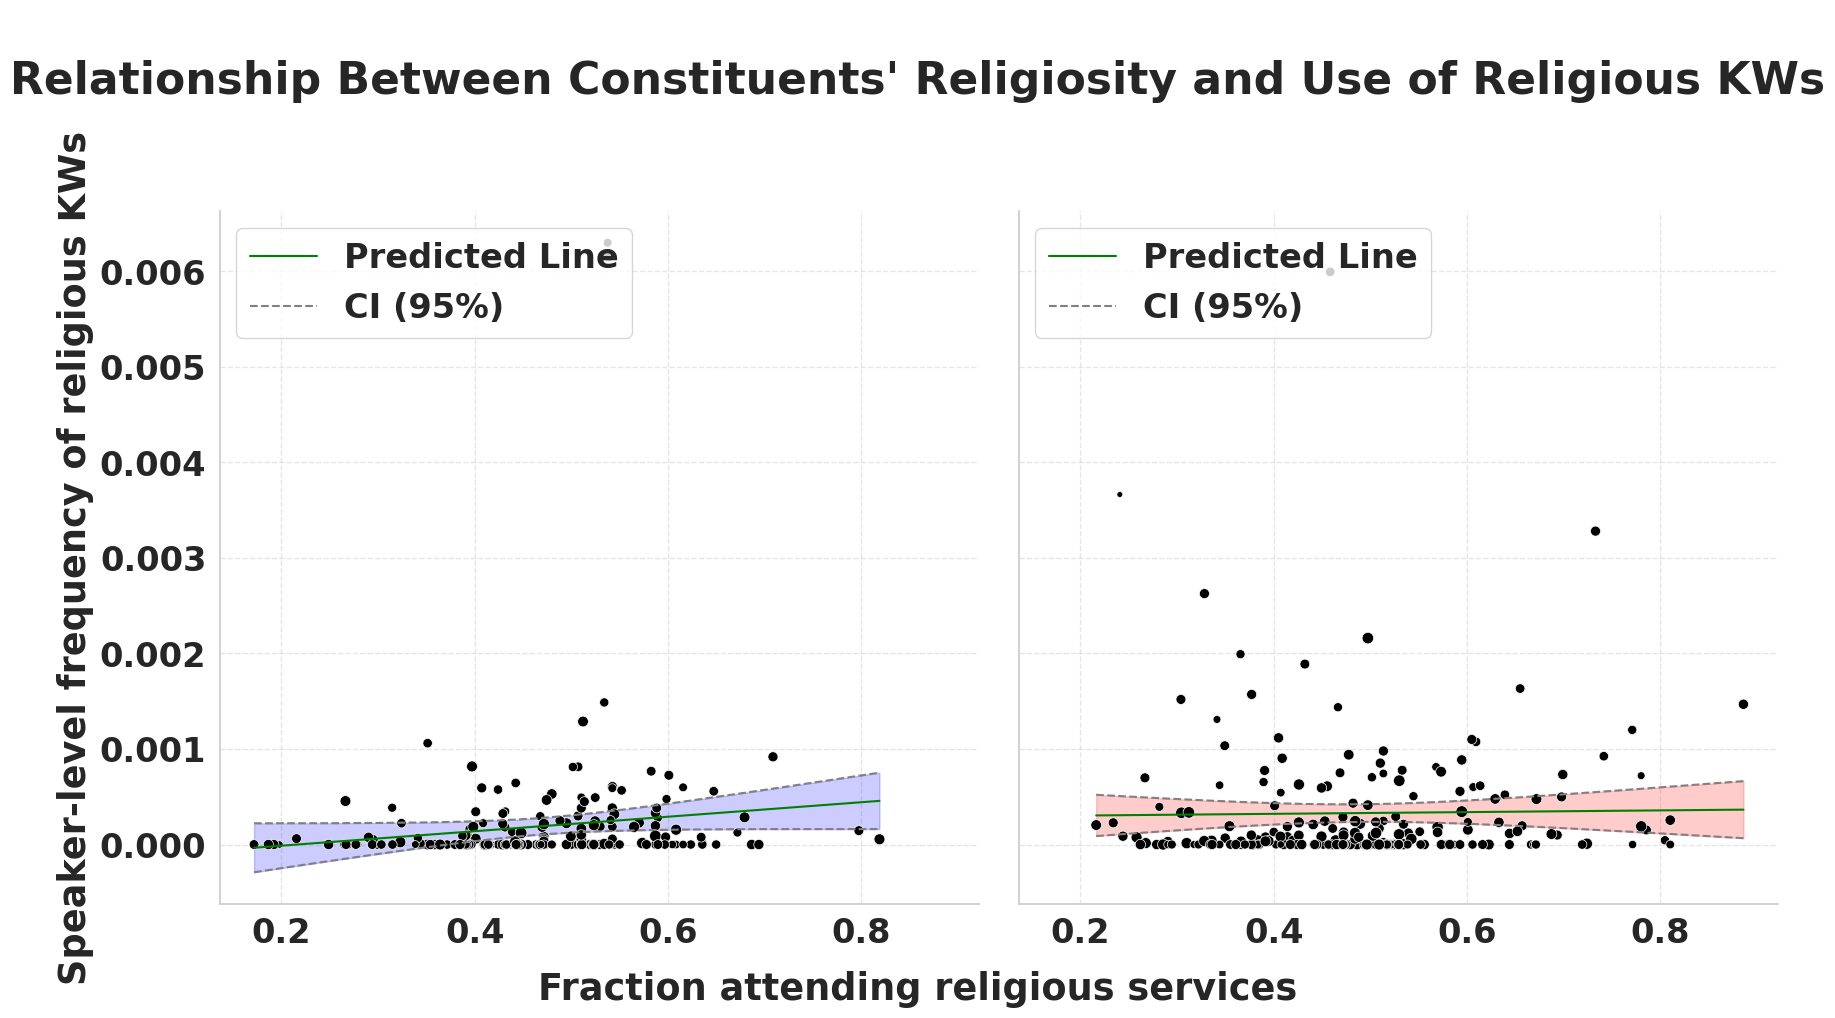

In [263]:
sns.set_context('notebook', font_scale=2.2, rc={'font.weight': 'bold'})
include_individual_title = False
wide_plot = True

# Create a constant column for the regression model
agg_dem = df_aggregated[df_aggregated['party'] == 'Democrat']
agg_dem.dropna(subset=['perc_adherents'], inplace=True)
agg_dem['constant'] = 1

# Define the independent and dependent variables
X = agg_dem[['constant', 'perc_adherents']]
y = agg_dem['lexical']

# Fit the regression model
model = sm.OLS(y, X).fit()
sg = Stargazer([model])
print(sg.render_latex())
pval = model.pvalues['perc_adherents']

# Get the predicted values and confidence intervals
pred = model.get_prediction(X)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Create a DataFrame with x values, predicted values, and confidence intervals
df = pd.DataFrame({'x': X['perc_adherents'], 'y_pred': pred_mean, 'ci_low': pred_ci[:, 0], 'ci_high': pred_ci[:, 1]})
df = df.sort_values('x')

# Create a figure with two subplots
if wide_plot:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 10), sharey=True, sharex=True)
else:
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 18), sharey=True, sharex=True)

# Plot the data, regression line, and confidence band on the first subplot
#ax1.fill_between(df['x'], df['ci_low'], df['ci_high'], color='grey', alpha=0.3, zorder=1)
agg_dem['log_size'] = np.log(agg_dem['num_speeches'])

sns.scatterplot(data=agg_dem, x='perc_adherents', y='lexical', color='black', ax=ax1, size='log_size', zorder=2, legend=False)
pred_line = sns.lineplot(data=df, x='x', y='y_pred', color='green', ax=ax1, zorder=3, label='Predicted Line')
low_ci_line = sns.lineplot(data=df, x='x', y='ci_low', color='grey', linestyle='--', ax=ax1, zorder=3, label='CI (95%)')
high_ci_line = sns.lineplot(data=df, x='x', y='ci_high', color='grey', linestyle='--', ax=ax1, zorder=3, legend=False)
ci_band = ax1.fill_between(df['x'], df['ci_low'], df['ci_high'], interpolate=True, color='blue', alpha=0.2)

handles1, labels1 = pred_line.get_legend_handles_labels()

if include_individual_title:
    ax1.set_title("Democratic House members, p=%.3f" % pval)
#ax1.set_xlabel("Fraction attending religious services")
ax1.legend(handles=handles1, labels=labels1, loc='upper left')

ax1.set_ylabel("Speaker-level frequency of religious KWs", weight='bold')
ax1.set_xlabel(None)

# Create a constant column for the regression model
agg_rep = df_aggregated[df_aggregated['party'] == 'Republican']
agg_rep.dropna(subset=['perc_adherents'], inplace=True)
agg_rep['constant'] = 1

# Define the independent and dependent variables
X = agg_rep[['constant', 'perc_adherents']]
y = agg_rep['lexical']

# Fit the regression model
model = sm.OLS(y, X).fit()
sg = Stargazer([model])
print(sg.render_latex())
pval = model.pvalues['perc_adherents']

# Get the predicted values and confidence intervals
pred = model.get_prediction(X)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Create a DataFrame with x values, predicted values, and confidence intervals
df = pd.DataFrame({'x': X['perc_adherents'], 'y_pred': pred_mean, 'ci_low': pred_ci[:, 0], 'ci_high': pred_ci[:, 1]})
df = df.sort_values('x')

# Plot the data, regression line, and confidence band on the second subplot

agg_rep['log_size'] = np.log(agg_rep['num_speeches'])
sns.scatterplot(data=agg_rep, x='perc_adherents', y='lexical', color='black', ax=ax2, size='log_size', zorder=5, legend=False)
pred_line_2 = sns.lineplot(data=df, x='x', y='y_pred', color='green', ax=ax2, zorder=6, label='Predicted Line')
sns.lineplot(data=df, x='x', y='ci_low', color='grey', linestyle='--', ax=ax2, zorder=6, label='CI (95%)')
sns.lineplot(data=df, x='x', y='ci_high', color='grey', linestyle='--', ax=ax2, zorder=6, legend=False)

handles2, labels2 = pred_line_2.get_legend_handles_labels()

# descriptive prints for debugging
print("df['x'] looks like this:")
print(df['x'].describe())
print("df['ci_low'] looks like this:")
print(df['ci_low'].describe())
print("df['ci_high'] looks like this:")
print(df['ci_high'].describe())

ax2.fill_between(df['x'], df['ci_low'], df['ci_high'], interpolate=True, color='red', alpha=0.2)
if include_individual_title:
    ax2.set_title("Republican House members, p=%.3f" % pval)
ax2.set_xlabel(None)
ax2.legend(handles=handles2, labels=labels2, loc='upper left')
#ax2.set_xlabel("Fraction attending religious services")
ax2.set_ylabel("Speaker-level frequency of religious KWs", weight='bold')
fig.text(0.5, 0, 'Fraction attending religious services', ha='center', va='center')
# Adjust the spacing between subplots

fig.suptitle("\nRelationship Between Constituents' Religiosity and Use of Religious KWs\n", weight='bold')

plt.tight_layout()

plt.show()

In [222]:
# print outliers in agg_dem and agg_rep
print("Outliers in agg_dem")
print(agg_dem[agg_dem['lexical'] > 0.003])
print("Outliers in agg_rep")
print(agg_rep[agg_rep['lexical'] > 0.003])

Outliers in agg_dem
      bio_id                     speaker   lexical     party  perc_adherents  \
341  S001157  Mr. DAVID SCOTT of Georgia  0.006297  Democrat        0.537678   
394  V000133                Mr. VAN DREW  0.006154  Democrat        0.538884   

     religion  num_general  num_christian  length  binary_lex  num_speeches  \
341   Baptist           10              0    1414       False             9   
394  Catholic          102              0   17620       False            72   

     bin  lex_bin  constant  log_size  
341    1        1         1  2.197225  
394    1        1         1  4.276666  
Outliers in agg_rep
      bio_id        speaker   lexical       party  perc_adherents  \
33   B001299      Mr. BANKS  0.005993  Republican        0.458543   
72   C001115      Mr. CLOUD  0.003280  Republican        0.733245   
257  M001194  Mr. MOOLENAAR  0.003663  Republican        0.240727   

                   religion  num_general  num_christian  length  binary_lex  \
33   

In [132]:
# years in agg_dem
print(set(agg_dem['year']))
# years in agg_rep
print(set(agg_rep['year']))

KeyError: 'year'

In [ ]:
agg_dem['constant'] = 1
agg_rep['constant'] = 1

/tmp/ipykernel_164344/1430810459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_dem['constant'] = 1
/tmp/ipykernel_164344/1430810459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_rep['constant'] = 1


In [ ]:
# negative binomial
from statsmodels.discrete import discrete_model

X = agg_dem[['constant', 'perc_adherents']]
y = agg_dem['lexical']
print("--- Democrats ---")
print(discrete_model.NegativeBinomial(y, X).fit().summary())

X = agg_rep[['constant', 'perc_adherents']]
y = agg_rep['lexical']
print("--- Republicans ---")
print(discrete_model.NegativeBinomial(y, X).fit().summary())

--- Democrats ---
Optimization terminated successfully.
         Current function value: 0.001718
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11


/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3737: RuntimeWarning: invalid value encountered in log
  start_params[-1] = np.log(start_params[-1])
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3737: RuntimeWarning: invalid value encountered in log
  start_params[-1] = np.log(start_params[-1])


                     NegativeBinomial Regression Results                      
Dep. Variable:                lexical   No. Observations:                  209
Model:               NegativeBinomial   Df Residuals:                      207
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Mar 2024   Pseudo R-squ.:                     nan
Time:                        22:37:06   Log-Likelihood:               -0.35899
converged:                       True   LL-Null:                           nan
Covariance Type:            nonrobust   LLR p-value:                       nan
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
constant         -10.5035     24.176     -0.434      0.664     -57.888      36.881
perc_adherents     3.9509     45.865      0.086      0.931     -85.943      93.845
alpha              0.0836     12.291

/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [ ]:
agg_dem

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/core/frame.py", line 1175, in _repr_html_
    else:
          
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1074, in to_html
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/html.py",

      bio_id                speaker   lexical     party  perc_adherents  \
1    A000148        Mr. AUCHINCLOSS  0.000122  Democrat        0.540766   
3    A000370              Ms. ADAMS  0.001435  Democrat        0.615832   
4    A000371            Mr. AGUILAR  0.000062  Democrat        0.424227   
7    A000376             Mr. ALLRED  0.000280  Democrat        0.589729   
10   A000380                Mr. AMO  0.000000  Democrat        0.519240   
..       ...                    ...       ...       ...             ...   
400  W000797  Ms. WASSERMAN SCHULTZ  0.000229  Democrat        0.443893   
404  W000808  Ms. WILSON of Florida  0.000856  Democrat        0.513608   
411  W000822    Mrs. WATSON COLEMAN  0.001063  Democrat        0.501724   
413  W000825             Ms. WEXTON  0.000000  Democrat        0.479904   
414  W000826               Ms. WILD  0.000100  Democrat        0.442961   

               religion  num_general  num_christian  length  binary_lex  bin  \
1                Je

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# have length, num_general, num_christian, perc_adherents, religion
agg_dem['num_relig'] = agg_dem['num_christian'] + agg_dem['num_general']
agg_rep['num_relig'] = agg_rep['num_christian'] + agg_rep['num_general']
model_formula = 'num_relig ~ perc_adherents'

model = smf.negativebinomial(formula=model_formula, data=agg_dem, offset=np.log(agg_dem['length']), loglike_method='nb2')
dem_model = model.fit()

print("--- Democrats ---")
print(dem_model.summary())

model = smf.negativebinomial(formula=model_formula, data=agg_rep, offset=np.log(agg_rep['length']), loglike_method='nb2')
rep_model = model.fit()

print("--- Republicans ---")
print(rep_model.summary())

Optimization terminated successfully.
         Current function value: 1.730319
         Iterations: 18
         Function evaluations: 23
         Gradient evaluations: 23
--- Democrats ---
                     NegativeBinomial Regression Results                      
Dep. Variable:              num_relig   No. Observations:                  209
Model:               NegativeBinomial   Df Residuals:                      207
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Mar 2024   Pseudo R-squ.:                 0.01738
Time:                        22:38:46   Log-Likelihood:                -361.64
converged:                       True   LL-Null:                       -368.03
Covariance Type:            nonrobust   LLR p-value:                 0.0003478
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept   

/tmp/ipykernel_164344/1914678610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_dem['num_relig'] = agg_dem['num_christian'] + agg_dem['num_general']
/tmp/ipykernel_164344/1914678610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_rep['num_relig'] = agg_rep['num_christian'] + agg_rep['num_general']


In [ ]:
(agg_dem['num_relig'] == 0).sum()

51

In [ ]:
(agg_dem['num_relig'] != 0).sum()

158

<Axes: xlabel='num_relig', ylabel='Count'>

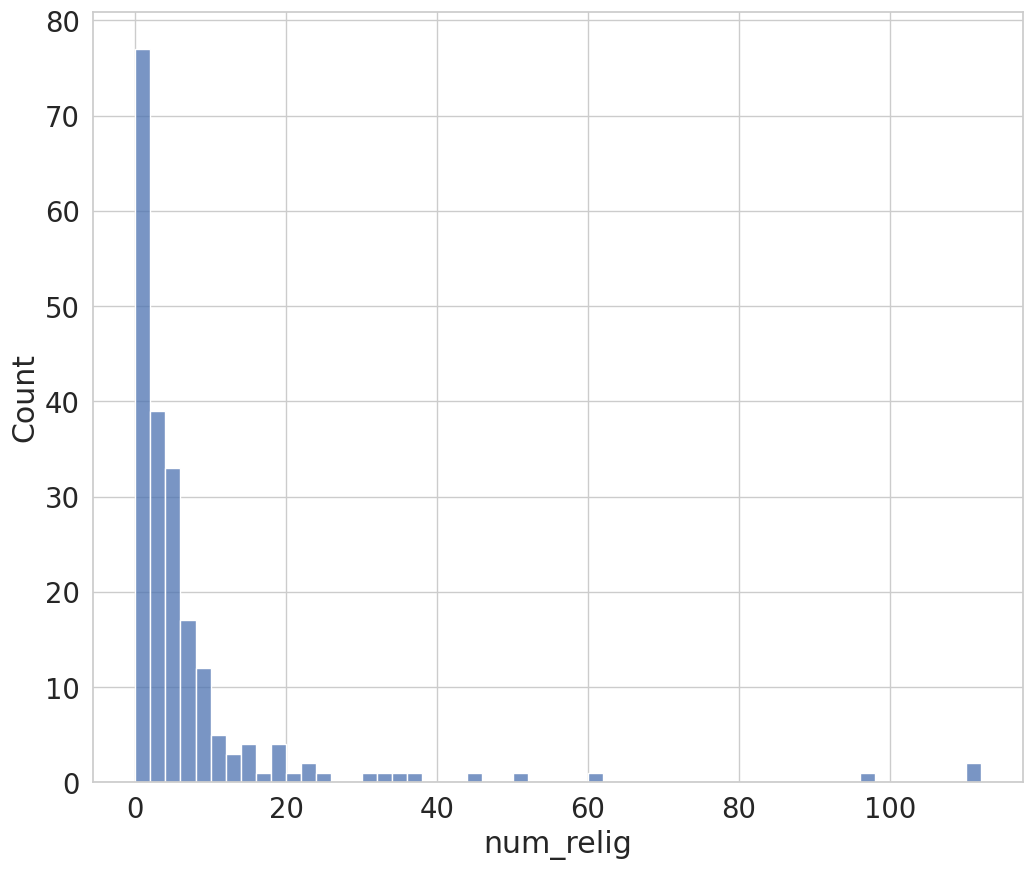

In [ ]:
sns.histplot(agg_dem['num_relig'])

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# have length, num_general, num_christian, perc_adherents, religion
agg_dem['num_relig'] = agg_dem['num_christian'] + agg_dem['num_general']
agg_rep['num_relig'] = agg_rep['num_christian'] + agg_rep['num_general']
covar = np.asarray(agg_dem[['perc_adherents', 'religion']])
model_formula = 'num_relig ~ perc_adherents'

model = sm.ZeroInflatedNegativeBinomialP(agg_dem['num_relig'], agg_dem['perc_adherents'], offset=np.log(agg_dem['length']), exog_infl=agg_dem[['length', 'constant']], inflation='logit')
dem_model = model.fit(method='nm', maxiter=5000, gtol=1e-12)

print("--- Democrats ---")
print(dem_model.summary())

covar = np.asarray(agg_rep[['perc_adherents', 'religion']])
model = sm.ZeroInflatedNegativeBinomialP(agg_rep['num_relig'], agg_rep['perc_adherents'], offset=np.log(agg_rep['length']), exog_infl=agg_rep[['length', 'constant']], inflation='logit')
rep_model = model.fit(method='nm', maxiter=5000, gtol=1e-12)

print("--- Republicans ---")
print(rep_model.summary())

/tmp/ipykernel_164344/3913677229.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_dem['num_relig'] = agg_dem['num_christian'] + agg_dem['num_general']
/tmp/ipykernel_164344/3913677229.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_rep['num_relig'] = agg_rep['num_christian'] + agg_rep['num_general']
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3935: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.lo

Optimization terminated successfully.
         Current function value: 3.095826
         Iterations: 340
         Function evaluations: 561
--- Democrats ---
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                         num_relig   No. Observations:                  209
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      208
Method:                                      MLE   Df Model:                            0
Date:                           Fri, 22 Mar 2024   Pseudo R-squ.:                 -0.2096
Time:                                   17:50:53   Log-Likelihood:                -647.03
converged:                                  True   LL-Null:                       -534.93
Covariance Type:                       nonrobust   LLR p-value:                       nan
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3935: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3936: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:5

Optimization terminated successfully.
         Current function value: 3.435743
         Iterations: 322
         Function evaluations: 559
--- Republicans ---
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                         num_relig   No. Observations:                  208
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      207
Method:                                      MLE   Df Model:                            0
Date:                           Fri, 22 Mar 2024   Pseudo R-squ.:                 -0.2158
Time:                                   17:50:53   Log-Likelihood:                -714.63
converged:                                  True   LL-Null:                       -587.79
Covariance Type:                       nonrobust   LLR p-value:                       nan
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [ ]:
mu = np.exp(dem_model.params['Intercept'])
p = 1 / (1 + np.exp(dem_model.params['Intercept']) * dem_model.params['perc_adherents'])
n = np.exp(dem_model.params['Intercept']) * p / (1-p)

/tmp/ipykernel_164344/1459484175.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(dem_model.params[0])
/tmp/ipykernel_164344/1459484175.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = 1 / (1 + np.exp(dem_model.params[0]) * dem_model.params[1])
/tmp/ipykernel_164344/1459484175.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = np.exp(dem_model.params[0]) * p / (1-p)


In [ ]:
import scipy.stats as stats

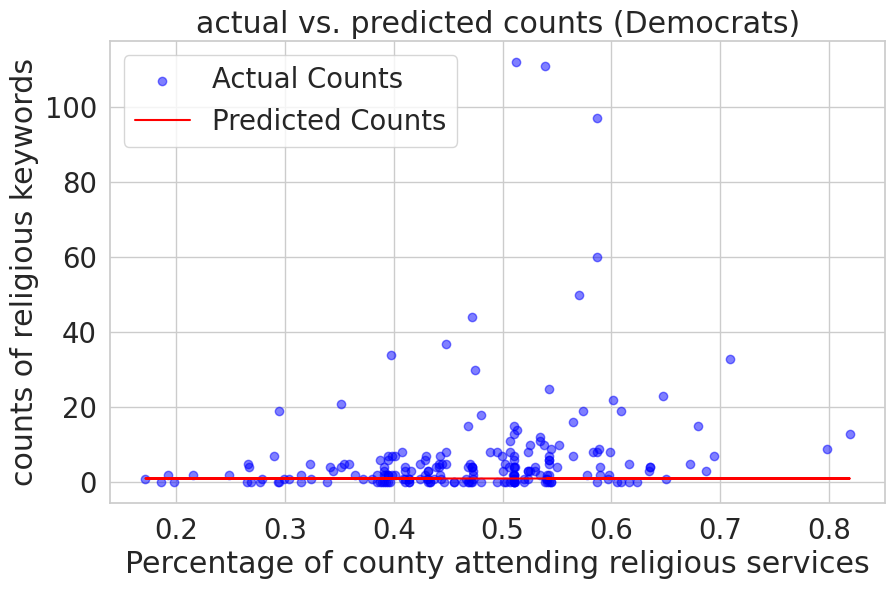

In [ ]:
x_main_sorted_idx = np.argsort(agg_dem['perc_adherents'])
y_true = dem_model.model.endog
y_pred = dem_model.predict(agg_dem['perc_adherents'])

plt.figure(figsize=(10, 6))

# Scatter plot for the observed data
plt.scatter(agg_dem['perc_adherents'], y_true, alpha=0.5, color='blue', label='Actual Counts')

# Line plot for the predicted values 
# or plt.scatter for another scatter plot with predictions using the marker and/or color of your choice
plt.plot(agg_dem['perc_adherents'], np.exp(y_pred), color='red', label='Predicted Counts')

# Labeling the plot
plt.xlabel('Percentage of county attending religious services')
plt.ylabel('counts of religious keywords')
plt.title('actual vs. predicted counts (Democrats)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3195121/871409513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_dem['bin'] = pd.cut(agg_dem['perc_adherents'], bins=10, labels=False)


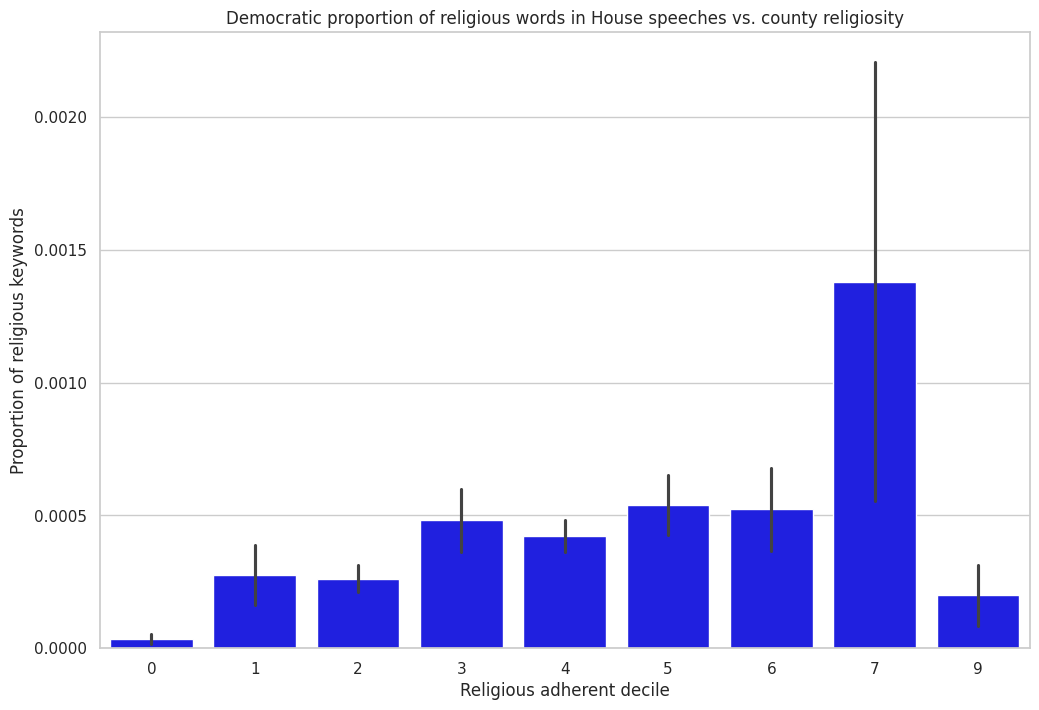

/tmp/ipykernel_3195121/871409513.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_rep['bin'] = pd.cut(agg_rep['perc_adherents'], bins=10, labels=False)


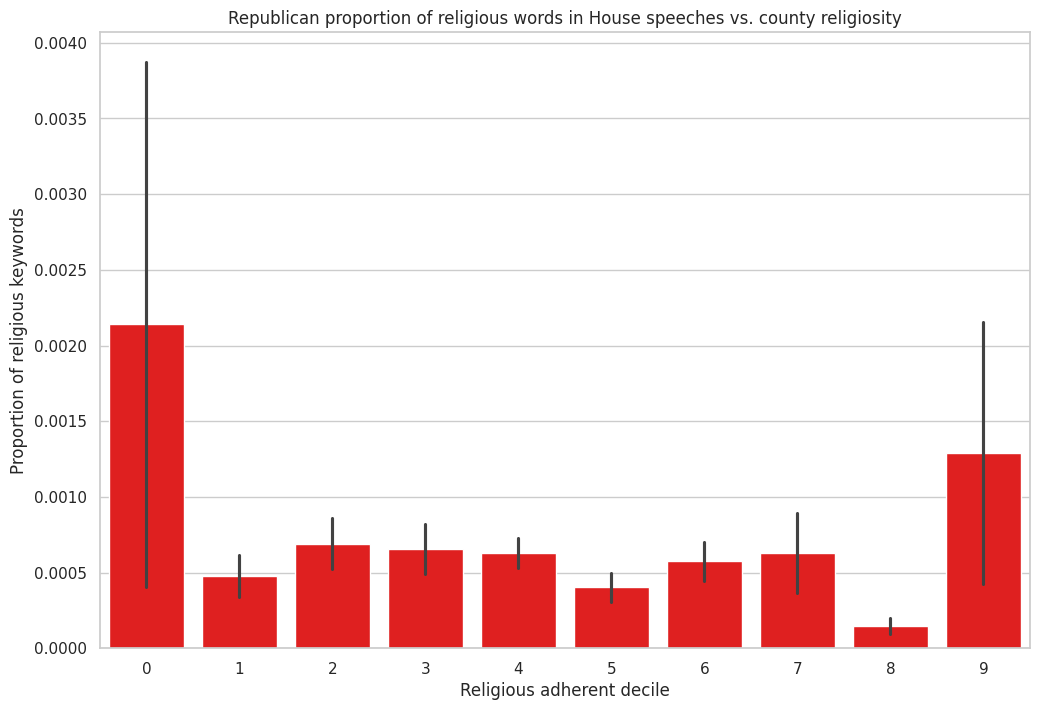

In [ ]:
# bin data

agg_dem['bin'] = pd.cut(agg_dem['perc_adherents'], bins=10, labels=False)

# plot

sns.set(rc={'figure.figsize':(12,8)}, style='whitegrid')
sns.barplot(data=agg_dem, x='bin', y='lexical', color='blue', errorbar='se')
plt.title("Democratic proportion of religious words in House speeches vs. county religiosity")
plt.xlabel("Religious adherent decile")
plt.ylabel("Proportion of religious keywords")
plt.show()

# repeat above with agg_rep
agg_rep['bin'] = pd.cut(agg_rep['perc_adherents'], bins=10, labels=False)

sns.set(rc={'figure.figsize':(12,8)}, style='whitegrid')
sns.barplot(data=agg_rep, x='bin', y='lexical', color='red', errorbar='se')
plt.title("Republican proportion of religious words in House speeches vs. county religiosity")
plt.xlabel("Religious adherent decile")
plt.ylabel("Proportion of religious keywords")
plt.show()

# with graphical model

In [ ]:
from scipy.stats import beta

a = 0.5
b = 0.5
# jeffreys prior

agg_dem = df_aggregated[df_aggregated['party'] == 'Democrat']
agg_rep = df_aggregated[df_aggregated['party'] == 'Republican']
bio_to_rate_list = {}
bio_to_perc_adherents = {}

for speaker in agg_dem['bio_id']:
    relig_words = agg_dem[agg_dem['bio_id'] == speaker]['num_general'] + agg_dem[agg_dem['bio_id'] == speaker]['num_christian']
    all_words = agg_dem[agg_dem['bio_id'] == speaker]['length']
    rates = beta.rvs(a + relig_words, b + all_words - relig_words, size=1000)
    bio_to_rate_list[speaker] = rates
    bio_to_perc_adherents[speaker] = agg_dem[agg_dem['bio_id'] == speaker]['perc_adherents'].values[0]

regressions = []
for i in range(0, 1000):
    x = []
    y = []
    for speaker in bio_to_rate_list:
        x.append(bio_to_perc_adherents[speaker])
        y.append(bio_to_rate_list[speaker][i])

    # add constant
    x = sm.add_constant(x)
    # fit the model
    model = sm.OLS(y, x).fit()
    regressions.append(model)

Mean Democratic p-values and standard errors: 
0.63823797537981
0.2255008240966982


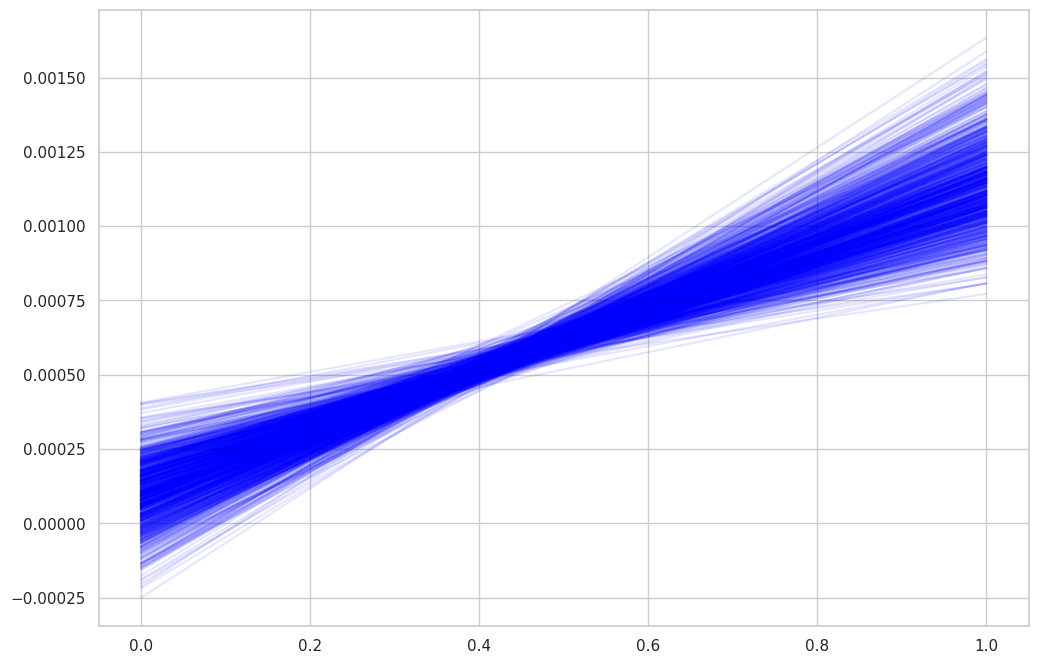

In [ ]:
p_values = [model.pvalues[0] for model in regressions]
print("Mean Democratic p-values and standard errors: ")
print(np.mean(p_values))
print(np.std(p_values))

for model in regressions:
    x = np.linspace(0, 1, 100)
    y = model.predict(sm.add_constant(x))
    plt.plot(x, y, color='blue', alpha=0.1)

plt.show()

In [ ]:
from scipy.stats import beta

a = 0.5
b = 0.5
# jeffreys prior

agg_dem = df_aggregated[df_aggregated['party'] == 'Democrat']
agg_rep = df_aggregated[df_aggregated['party'] == 'Republican']
bio_to_rate_list = {}
bio_to_perc_adherents = {}

for speaker in agg_rep['bio_id']:
    relig_words = agg_rep[agg_rep['bio_id'] == speaker]['num_general'] + agg_rep[agg_rep['bio_id'] == speaker]['num_christian']
    all_words = agg_rep[agg_rep['bio_id'] == speaker]['length']
    rates = beta.rvs(a + relig_words, b + all_words - relig_words, size=1000)
    bio_to_rate_list[speaker] = rates
    bio_to_perc_adherents[speaker] = agg_rep[agg_rep['bio_id'] == speaker]['perc_adherents'].values[0]

regressions = []
for i in range(0, 1000):
    x = []
    y = []
    for speaker in bio_to_rate_list:
        x.append(bio_to_perc_adherents[speaker])
        y.append(bio_to_rate_list[speaker][i])

    # add constant
    x = sm.add_constant(x)
    # fit the model
    model = sm.OLS(y, x).fit()
    regressions.append(model)

Mean Republican p-values and standard errors: 
0.0025002542477449916
0.004284775633397418


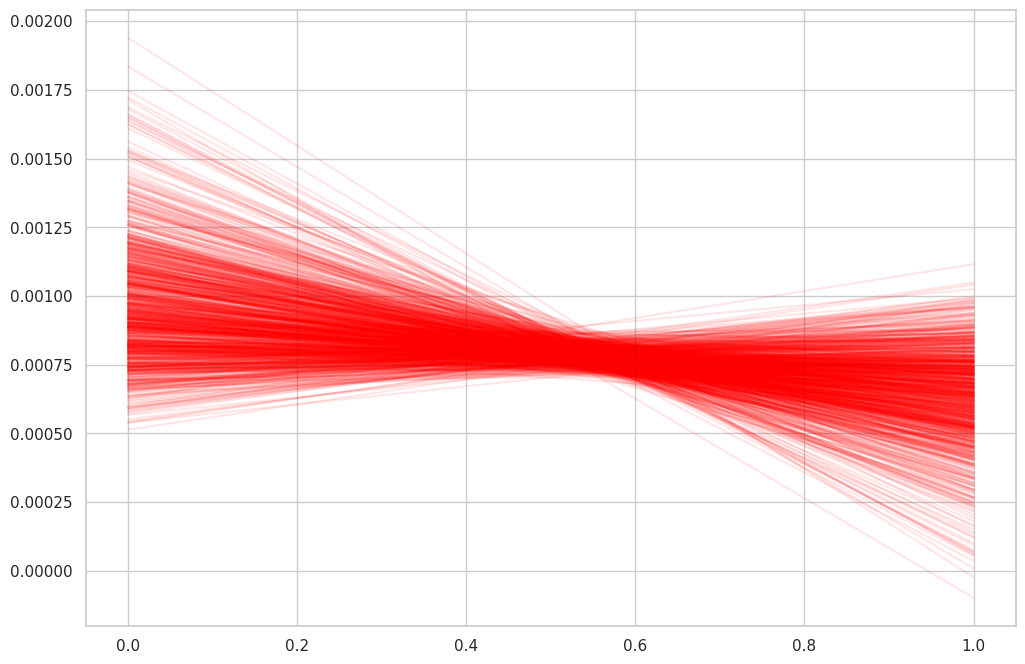

In [ ]:
p_values = [model.pvalues[0] for model in regressions]
print("Mean Republican p-values and standard errors: ")
print(np.mean(p_values))
print(np.std(p_values))

for model in regressions:
    x = np.linspace(0, 1, 100)
    y = model.predict(sm.add_constant(x))
    plt.plot(x, y, color='red', alpha=0.1)

plt.show()

# references and religiosity of district

# religious identity checking

In [169]:
religion = '/data/laviniad/congress_errata/bioguide_to_religion.json'
import json
with open(religion, 'r') as f:
    bio_to_religion = json.load(f)

def get_religion(x):
    if x in bio_to_religion.keys():
        return bio_to_religion[x]
    return 'unknown'

df_aggregated['religion'] = df_aggregated['bio_id'].apply(lambda x: get_religion(x)) # need to redo
df_118_117['religion'] = df_118_117['bio_id'].apply(lambda x: get_religion(x)) # need to redo

In [170]:
from data.data_utils import get_states

states = get_states() # returns full name: abbreviation dictionary

county_data = pd.read_csv('/home/laviniad/projects/CausalMLProjectData/data/county_religion.csv')

def get_state(x):
    if x in states.keys():
        return states[x]
    return 'NONE'

def get_county_code_with_state(row):
    state_code = str(row['STATE'])
    county_name = str(row['County Name']) # if NaN, not going to index anyways
    county_name = county_name.upper().replace(' COUNTY', '').replace(' PARISH', '')

    return county_name + ', ' + state_code
    
print("Loading county and state data")
county_data['STATE'] = county_data['State Name'].apply(get_state).apply(lambda x: x.upper())
county_data['adherent_pop'] = county_data['Adherents'].apply(lambda x: float(str(x).replace(',', '')))
county_data['total_pop_2020'] = county_data['2020 Population'].apply(lambda x: float(str(x).replace(',', '')))
state_data = county_data.groupby('STATE').agg('sum').reset_index() # can only really use adherent_pop and total_pop_2020 after this

print("Getting adherent percentage stats")
state_data['perc_adherent_2020'] = state_data['adherent_pop'] / state_data['total_pop_2020']
county_data['county_code'] = county_data.apply(get_county_code_with_state, axis=1)
county_data['perc_adherent_2020'] = county_data['adherent_pop'] / county_data['total_pop_2020']
county_to_adherent_pop = {k: v for k,v in zip(county_data['county_code'], county_data['adherent_pop'])}
county_to_perc_adherents = {k: v for k,v in zip(county_data['county_code'], county_data['perc_adherent_2020'])}

Loading county and state data
Getting adherent percentage stats


In [171]:
# redo county assignment
county_data = "/data/laviniad/congress_errata/bioguide_to_county.json"
with open(county_data, 'r') as f:
    bio_to_county = json.load(f)

bio_to_perc_adherents = {}
for bio in bio_to_county:
    county = bio_to_county[bio]
    if county in county_to_perc_adherents:
        bio_to_perc_adherents[bio] = county_to_perc_adherents[county]

def get_perc_adherents(x):
    if x in bio_to_perc_adherents.keys():
        return bio_to_perc_adherents[x]
    return None

df_aggregated['perc_adherents'] = df_aggregated['bio_id'].apply(get_perc_adherents)

In [172]:
df_aggregated['perc_adherents']

0      0.666401
1      0.540766
2      0.466593
3      0.615832
4      0.424227
         ...   
413    0.479904
414    0.442961
415    0.529525
416    0.328338
417    0.370229
Name: perc_adherents, Length: 417, dtype: float64

In [173]:
df_aggregated = df_aggregated[df_aggregated['religion'] != 'unknown']
# label religions not in top 12 as "other"
top_12 = df_aggregated['religion'].value_counts().index[:12]
df_aggregated['religion'] = df_aggregated['religion'].apply(lambda x: x if x in top_12 else 'Other')

In [174]:
top_12

Index(['Catholic', 'Protestant unspecified', 'Baptist', 'Methodist',
       'Unspecified Protestant', 'Jewish', 'Latin Catholic', 'Lutheran',
       'Episcopalian', 'Presbyterian', 'Don't know/refused',
       'Nondenominational'],
      dtype='object', name='religion')

<Axes: xlabel='lexical', ylabel='religion'>

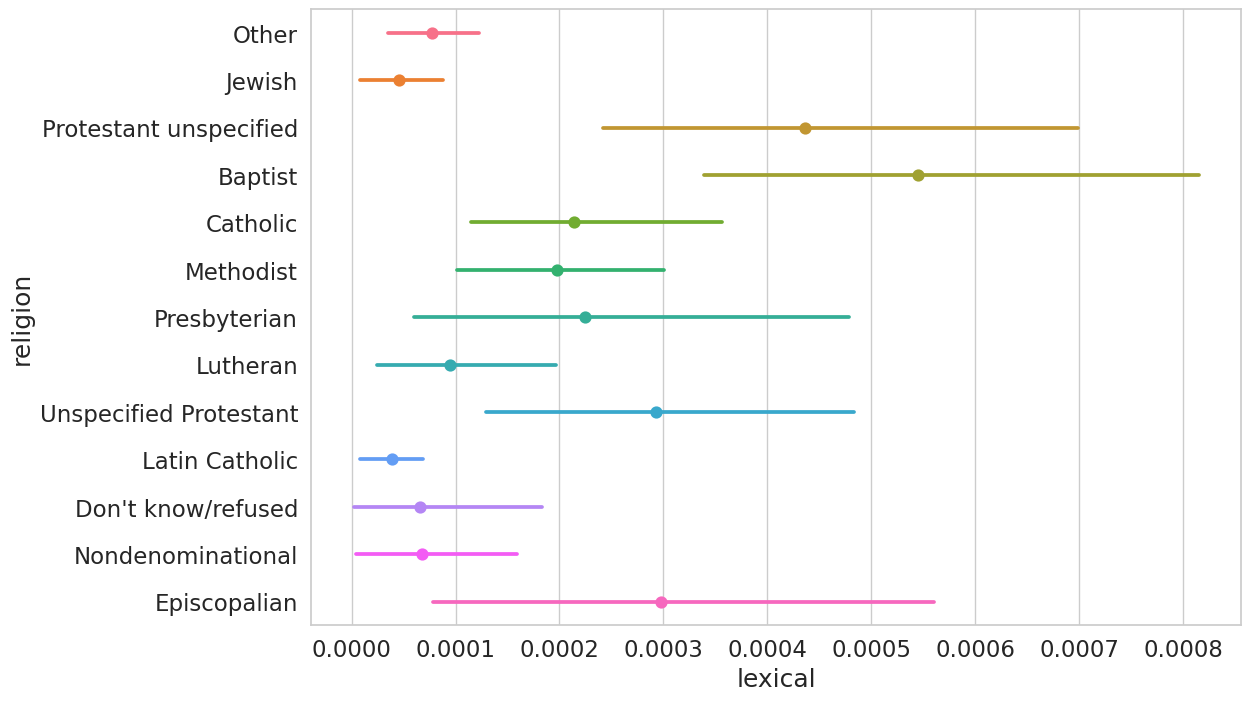

In [175]:
sns.set(font_scale=1.5, rc={'figure.figsize':(12,8)}, style='whitegrid')
sns.pointplot(data=df_aggregated, y='religion', x='lexical', hue='religion')

In [180]:
df_118_117['religion'] = df_118_117['religion'].apply(lambda x: 'Protestant' if x == 'Protestant unspecified' else x)

In [181]:
df_118_117.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/core/frame.py", line 1175, in _repr_html_
    else:
          
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1074, in to_html
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/html.py",

         bio_id  congress_num  year       date chamber                speaker  \
297426  N000147           117  2021 2021-01-04   House             Ms. NORTON   
297427  S001196           117  2021 2021-01-04   House           Ms. STEFANIK   
297428  H001068           117  2021 2021-01-04   House            Mr. HUFFMAN   
297429  L000551           117  2021 2021-01-04   House  Ms. LEE of California   
297430  J000032           117  2021 2021-01-04   House        Ms. JACKSON LEE   

                                                     text  month_code  month  \
297426  Ms. NORTON. Madam Speaker, I rise today to int...           1      1   
297427  Ms. STEFANIK. Madam Speaker, I rise today to h...           1      1   
297428  Mr. HUFFMAN. Madam Speaker, I regret that due ...           1      1   
297429  Ms. LEE of California. Madam Speaker, I rise t...           1      1   
297430  Ms. JACKSON LEE. Madam Speaker, I rise today t...           1      1   

       gender  ...  faith   pray

In [182]:
df_relig = []
# at speaker level
for religion in df_118_117['religion'].unique():
    rows = df_118_117[df_118_117['religion'] == religion]
    yes_religious_token_count = len(rows[rows['binary_lex'] == 1])
    no_religious_token_count = len(rows[rows['binary_lex'] == 0])
    result_dict = {'religion': religion, 'yes_relig': yes_religious_token_count, 'no_relig': no_religious_token_count}
    if (religion != 'nonlabeled') and (religion in top_12):
        df_relig.append(result_dict)
    elif not (religion in top_12):
        if 'Other' in [x['religion'] for x in df_relig]:
            other_row = [x for x in df_relig if x['religion'] == 'Other'][0]
            other_row['yes_relig'] += yes_religious_token_count
            other_row['no_relig'] += no_religious_token_count
        else:
            df_relig.append({'religion': 'Other', 'yes_relig': yes_religious_token_count, 'no_relig': no_religious_token_count})

df_relig = pd.DataFrame(df_relig)

In [183]:
# unspecified protestant
df_relig.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/core/frame.py", line 1175, in _repr_html_
    else:
          
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1074, in to_html
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  File "/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/pandas/io/formats/html.py",

       religion  yes_relig  no_relig
0         Other        975     16221
1      Catholic        903     18214
2       Baptist        674      7296
3  Episcopalian         97      2386
4        Jewish        116      6082

In [185]:
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=2.2, rc={'figure.figsize':(20,16)}, style='whitegrid')

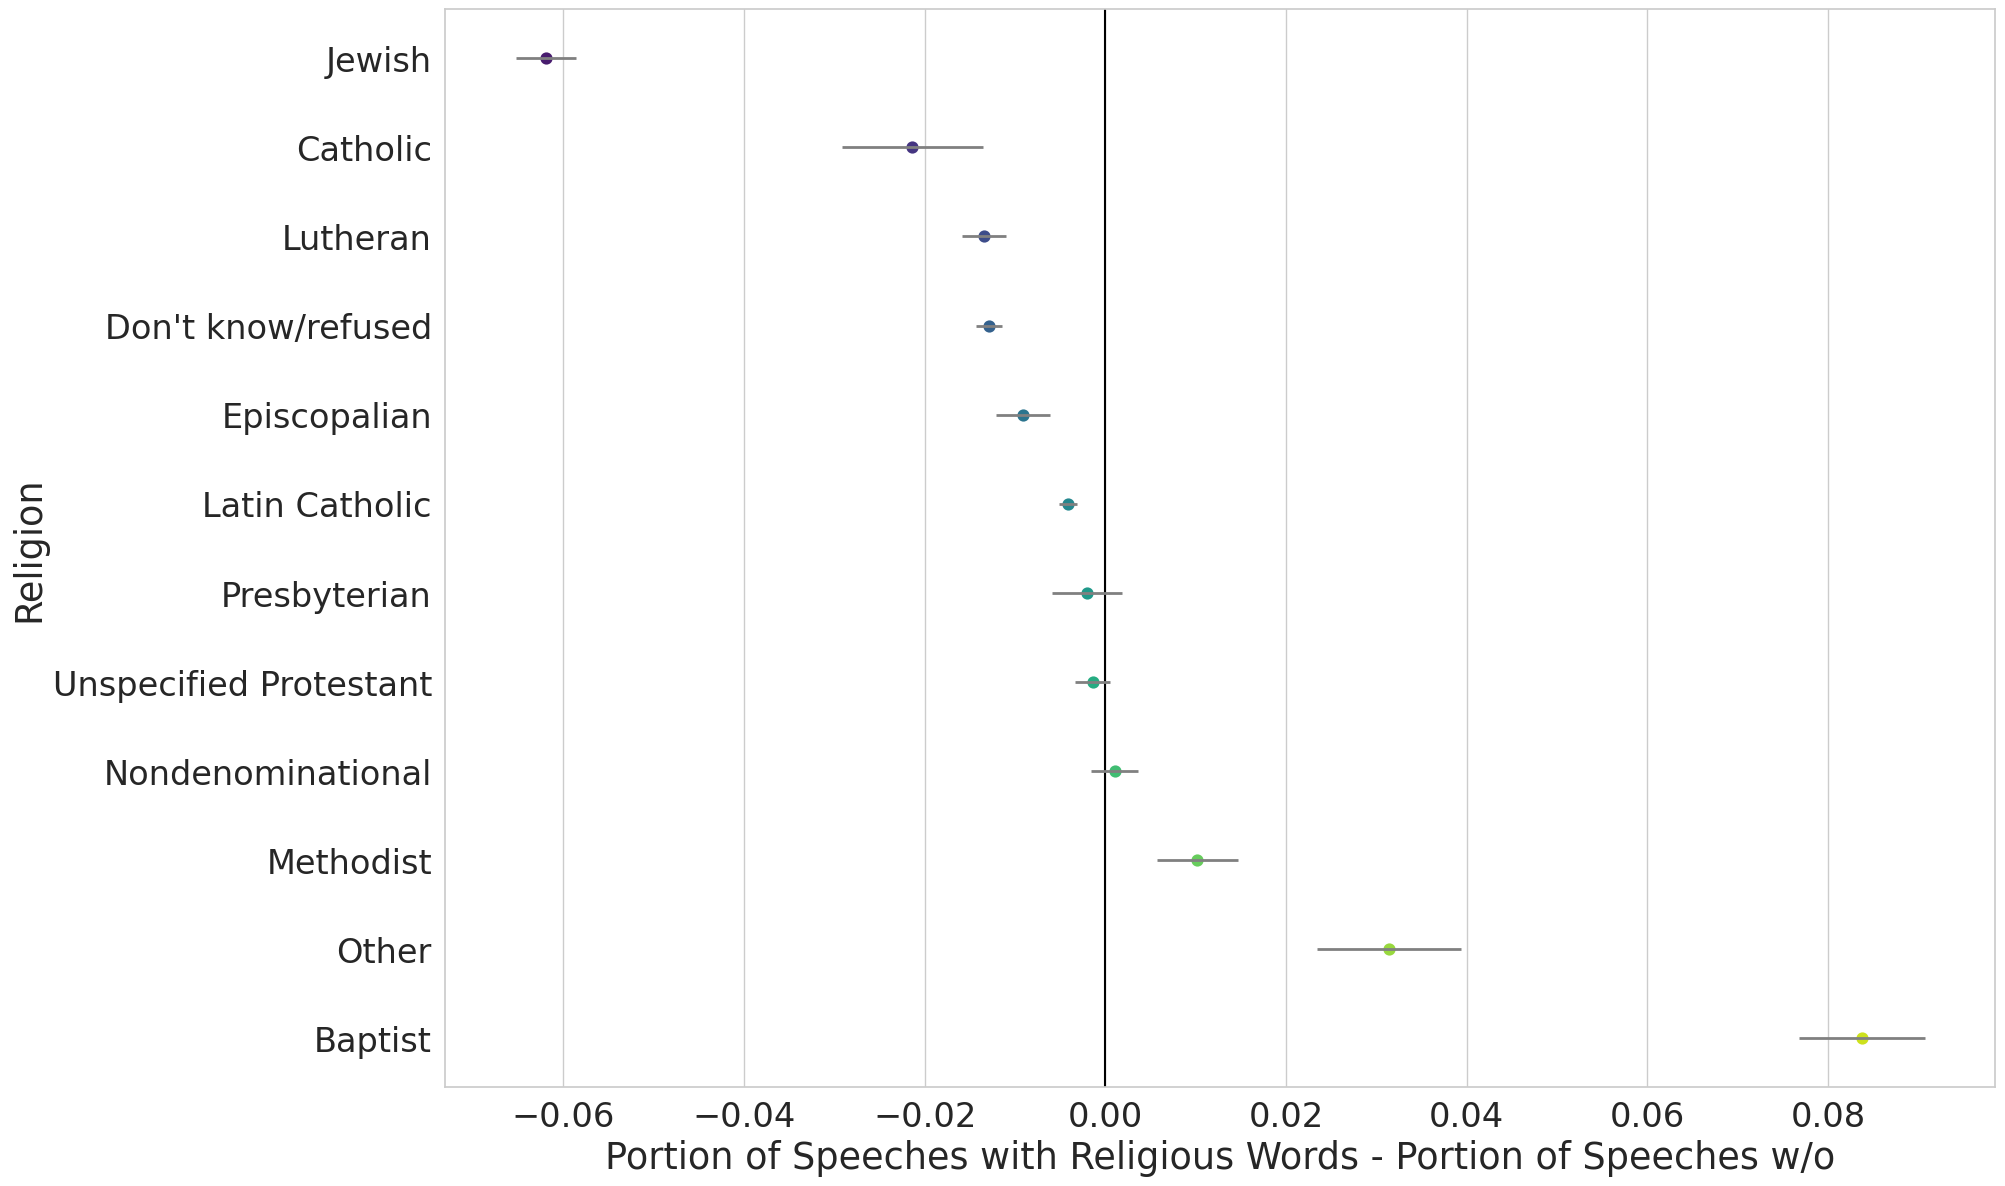

In [189]:
df_relig['no_relig_dist'] = df_relig['no_relig'] / df_relig['no_relig'].sum()
df_relig['yes_relig_dist'] = df_relig['yes_relig'] / df_relig['yes_relig'].sum()
df_relig['diff_dist'] = df_relig['yes_relig_dist'] - df_relig['no_relig_dist']

def proportion_std_error(count, total):
    proportion = count / total
    return np.sqrt(proportion * (1 - proportion) / total)

df_relig['no_relig_std'] = df_relig.apply(lambda row: proportion_std_error(row['no_relig'], df_relig['no_relig'].sum()), axis=1)
df_relig['yes_relig_std'] = df_relig.apply(lambda row: proportion_std_error(row['yes_relig'], df_relig['yes_relig'].sum()), axis=1)

df_relig['diff_sd'] = np.sqrt(df_relig['no_relig_std']**2 + df_relig['yes_relig_std']**2)
df_relig.sort_values('diff_dist', inplace=True)
topics = df_relig.index.tolist()
means = df_relig['diff_dist'].values
errors = df_relig['diff_sd'].values

# plot difference by topic
plt.figure(figsize=(20, 14))
#plt.xlim(-0.004, 0.0025)
sns.pointplot(data=df_relig, x='diff_dist', y='religion', hue='religion', palette='viridis')
# plot errors
plt.axvline(x=0, color='black')
plt.errorbar(data=df_relig, y='religion', x='diff_dist', xerr='diff_sd', ecolor='gray', lw=2, fmt='none')
plt.xlabel('Portion of Speeches with Religious Words - Portion of Speeches w/o')
plt.ylabel('Religion')
plt.show()

In [ ]:
# log odds for each religious group wrt being republican
df_aggregated['is_rep'] = (df_aggregated['party'] == 'Republican')
df_aggregated['is_rep'] = df_aggregated['is_rep'].astype(int)

religions = df_aggregated['religion'].unique()
for r in religions:
    rows = df_aggregated[df_aggregated['religion'] == r]
    perc_republican = rows['is_rep'].mean() * 100
    num_people = len(rows)
    print(f"%.2f %% of {r} ({num_people} congresspeople) are Republicans" % perc_republican)

40.00 % of Other (25 congresspeople) are Republicans
4.55 % of Jewish (22 congresspeople) are Republicans
71.05 % of Unspecified Protestant (76 congresspeople) are Republicans
58.18 % of Baptist (55 congresspeople) are Republicans
46.96 % of Latin Catholic (115 congresspeople) are Republicans
44.00 % of Methodist (25 congresspeople) are Republicans
46.67 % of Presbyterian (15 congresspeople) are Republicans
53.33 % of Lutheran (15 congresspeople) are Republicans
0.00 % of Unknown/refused to state (14 congresspeople) are Republicans
66.67 % of Nondenominational Protestant (12 congresspeople) are Republicans
53.33 % of Episcopalian (15 congresspeople) are Republicans
40.00 % of Greek Orthodox (5 congresspeople) are Republicans
100.00 % of The Church of Jesus Christ of Latter-day Saints (5 congresspeople) are Republicans


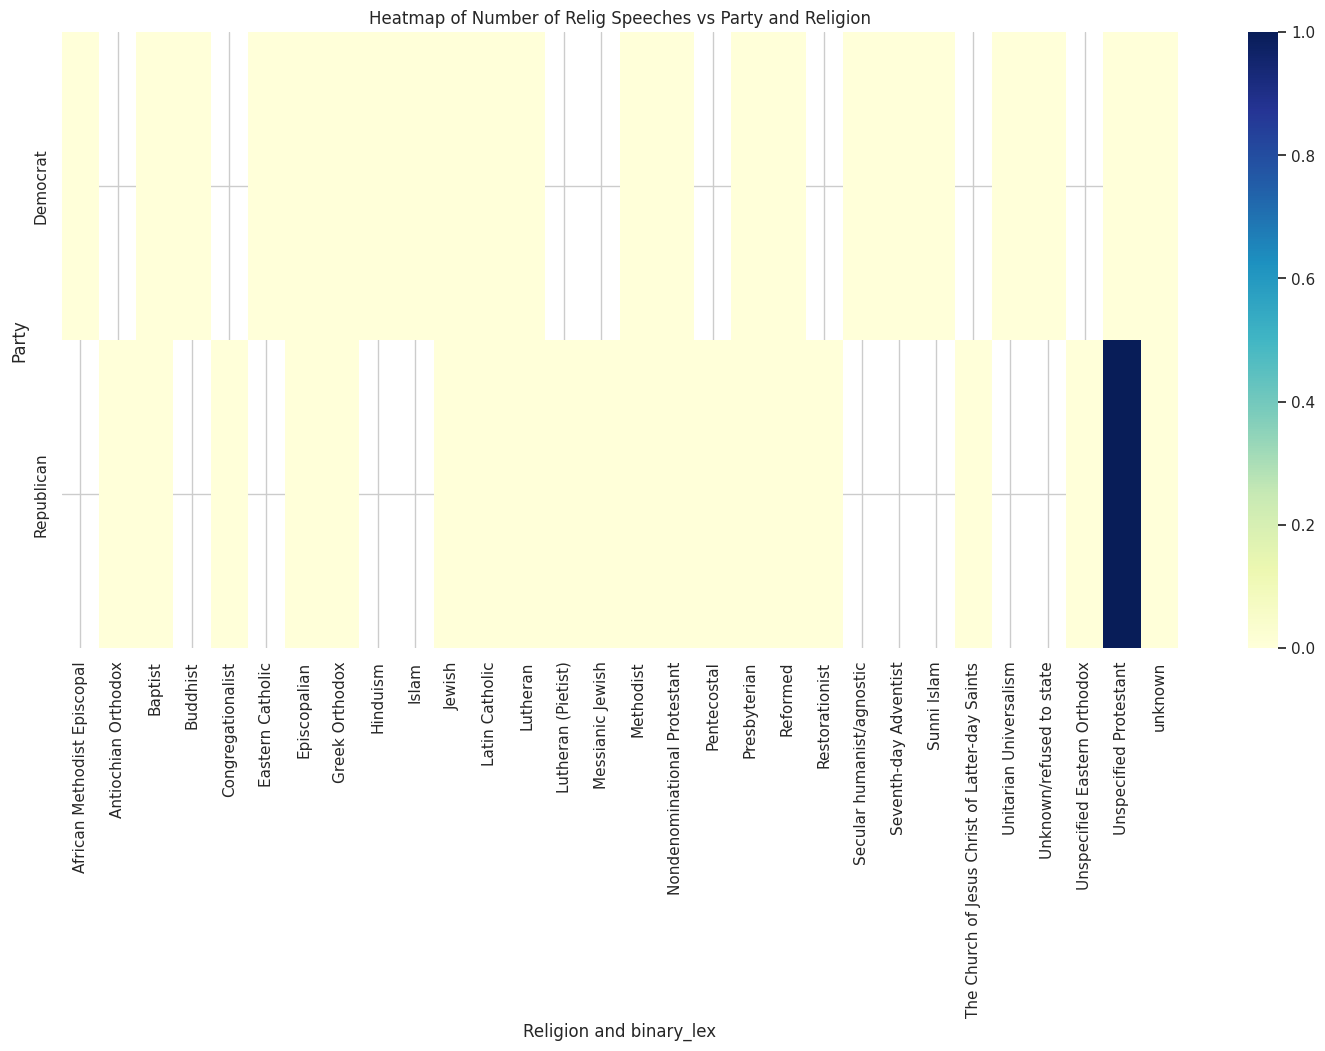

In [ ]:
crosstab = pd.crosstab(df_aggregated['party'], [df_aggregated['religion']], values=df_aggregated['binary_lex'], aggfunc='sum')

plt.figure(figsize=(18, 8))
sns.heatmap(crosstab, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Number of Relig Speeches vs Party and Religion')
plt.xlabel('Religion and binary_lex')
plt.ylabel('Party')
plt.show()